## Getting things ready

By default this notebook will be running from the `notebooks` directory, let's install the root of this repository as a package to get the dependencies. Make sure that you're using a kernel that's based on a new virtual environment to prevent any dependency conflicts.

In [1]:
import sys

!{sys.executable} -m pip install -c ../constraints.txt -e ..[dev,gcp,interactive]

Obtaining file:///home/jupyter/gcp-mlops-demo-main
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for gcp-mlops-demo (pyproject.toml) ... done
  Created wheel for gcp-mlops-demo: filename=gcp_mlops_demo-0.8.0.dev0-0.editable-py3-none-any.whl size=4655 sha256=6c1941f1f245f42512e632ff4a10d2eec37d1ae6887401a3796b196fe74a0e03
  Stored in directory: /var/tmp/pip-ephem-wheel-cache-eamux3i5/wheels/b6/14/e9/5adedc1fcdb2e46f7febf8ee233009b58bd5fbc960655b00db
Successfully built gcp-mlops-demo
  Attempting uninstall: gcp-mlops-demo
    Found existing installation: gcp-mlops-demo 0.8.0.dev0
    Uninstalling gcp-mlops-demo-0.8.0.dev0:
      Successfully uninstalled gcp-mlops-demo-0.8.0.dev0


> In principle we don't need any of the optional packages to run the training code. We've included the `interactive` dependencies so that we can visualize data as part of the exploration. The `gcp` dependencies are for getting the data from BigQuery and **submitting** the training code to Vertex AI.

Now we've installed all dependencies, we need to restart the kernel to be able to use those. **Please wait until the kernel is restarted** before you continue with the next steps; after the next cell is executed you'll be prompted with a dialog indicating that the _Kernel is restarting_.

In [2]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

We also would like to be able to use our module files without reinstalling it after every change, so let's add our package root to the `sys.path`.

In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath('../src'))

One final step before we get started, we'd like our modules to be automatically reloaded after every change. This way if we make any changes to our scripts things will be available immediately.

In [2]:
%load_ext autoreload
%autoreload 2

## Using Vertex AI for ad-hoc training

Now we're ready to start with our first introduction to Vertex AI. The objective of this notebook is to illustrate how to use the capabilities of Vertex AI to train a custom model with no code changes.

We've already prepared some simple code to train a simple _Random Forest Classifier_ using the popular _scikit-learn_ library. Please go ahead and check the source code to see that it's a very simple model and has no dependencies on Vertex AI at all. It returns an `accuracy` score when training is complete and stores the model file as well as some metrics in the provided output directory.

In [3]:
from trainer import task

task.train(training_data_dir="../data", validation_data_dir=None, output_dir="../outputs")

0.772

Well, running this locally is fine, but we're using local data and we're bound to the local hardware. Although we're running this on Vertex AI Workbench, where you also have access to more diverse hardware, we'll try to run our training script on Vertex AI where you have access to bigger, badder :) machines with many CPUs, large RAMs and even custom hardware such as GPUs and TPUs. For the sake of this experiment we'll stick to a simple machine, but you get the gist :)

We've got a few more steps before we can submit our job.

### Prereqs...

In [4]:
PROJECT_ID = "[your-project-id]"
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list project --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

Project ID: bg-test-run-mlops-2025-06-06


For many services on GCP you need to define the region (location) where things should be executed. The `us-central1` (Iowa, US) is the default for most services, you can change it to another region, but then you need to make sure that you're consistent in your choice in other places as well.

In [5]:
REGION = "[your-region]"

if REGION == "[your-region]":
    REGION = "us-central1"
    print("Region:", REGION) 

Region: us-central1


We'll use the project id as the bucket name to make sure that we don't get any collisions.

In [6]:
BUCKET_URI = f"gs://{PROJECT_ID}"

The command below checks if the bucket already exists, if not creates a new one.

In [7]:
!gsutil ls -b $BUCKET_URI &> /dev/null || gsutil mb -l $REGION $BUCKET_URI

Creating gs://bg-test-run-mlops-2025-06-06/...


### No data, no training

Well, we'll also need some training data for our model. The sample code is based on the New York City Taxi fare data, also available in the BigQuery public dataset. We already have a sample our repository for testing purposes (`data/sample.csv`), but for the sake of completeness, we'll get a more fresh and larger snapshot for the Vertex AI training job.

As our goal is to predict whether a taxi trip will yield a tip that's more than %20 of the fare, we'll do some pre-processing in BQ. The following snippet will load a sample of this data into a pandas DataFrame.

In [8]:
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """SELECT
        EXTRACT(MONTH from pickup_datetime) as trip_month,
        EXTRACT(DAY from pickup_datetime) as trip_day,
        EXTRACT(DAYOFWEEK from pickup_datetime) as trip_day_of_week,
        EXTRACT(HOUR from pickup_datetime) as trip_hour,
        TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, SECOND) as trip_duration,
        trip_distance,
        payment_type,
        pickup_location_id as pickup_zone,
        pickup_location_id as dropoff_zone,
        IF((SAFE_DIVIDE(tip_amount, fare_amount) >= 0.2), 1, 0) AS tip_bin
    FROM
        `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2021` TABLESAMPLE SYSTEM (1 PERCENT)
    LIMIT 10000"""
job = client.query(query)
df = job.to_dataframe()

Let's have a quick look at the data distribution, typically the exploration would be more comprehensive, but for the sake of this example we'll stick to something basic, looking at the trip duration (in seconds).

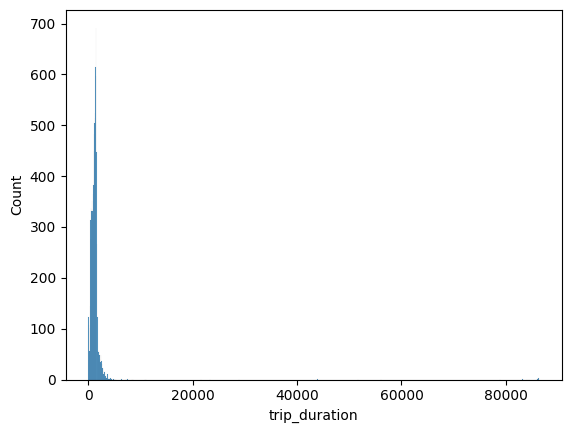

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df.trip_duration);

Hmm, there seems to be some outliers (trips of >10 hours), and 0 seconds, let's filter those out. The snippet below will keep only the trips that are between 5 minutes and 3 hours.

In [10]:
df = df[df.trip_duration.between(300, 10800)]

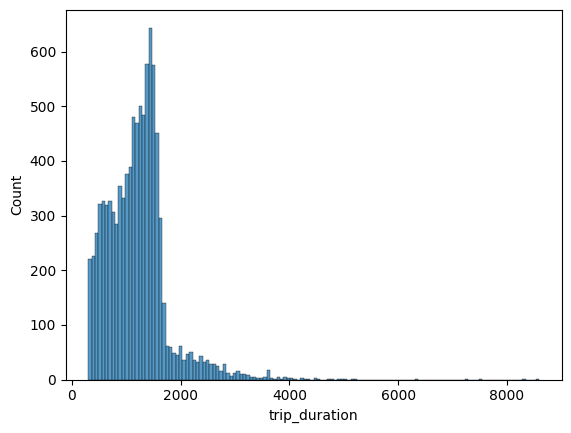

In [11]:
sns.histplot(df.trip_duration);

Now we can put that sample data into GCS so that we can start running our training code (we're now directly writing to the GCS bucket from the pandas data frame).

In [12]:
df.to_csv(f"{BUCKET_URI}/data/sample/sample.csv", header=True, index=False)

After putting the sample data into GCS, now it's time for the codebase. In order to run our codebase we first need to bundle it in the right format and put it on GCS.

In [13]:
# let's run this from the root of this repository
!{sys.executable} -m build --sdist ..

* Creating virtualenv isolated environment...
* Installing packages in isolated environment... (setuptools>=61, wheel)
* Getting build dependencies for sdist...
/var/tmp/build-env-galx9vd0/lib/python3.10/site-packages/setuptools/config/_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
!!

        ********************************************************************************
        Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).

        By 2026-Feb-18, you need to update your project and remove deprecated calls
        or your builds will no longer be supported.

        See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
        ********************************************************************************

!!
  corresp(dist, value, root_dir)
running egg_info
writ

Let's copy the generated package on GCS

In [14]:
!gsutil -m cp ../dist/*.tar.gz $BUCKET_URI/code/

Copying file://../dist/gcp_mlops_demo-0.8.0.dev0.tar.gz [Content-Type=application/x-tar]...
/ [1/1 files][  9.7 KiB/  9.7 KiB] 100% Done                                    
Operation completed over 1 objects/9.7 KiB.                                      


### Hooray, time for Vertex AI 

It's finally time to submit our job to Vertex AI. Since our model is a simple _scikit-learn_ model, we can use one of the pre-built containers.

In [15]:
pkg_name = !ls -1t ../dist | head -n1
print(f"Latest package: {pkg_name[0]}")

Latest package: gcp_mlops_demo-0.8.0.dev0.tar.gz


We'll need to define the job first:

In [16]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=f"{BUCKET_URI}/staging")

job = aiplatform.CustomPythonPackageTrainingJob(
    display_name="my-first-training",
    python_package_gcs_uri=f"{BUCKET_URI}/code/{pkg_name[0]}",
    python_module_name="trainer.task",
    container_uri="us-docker.pkg.dev/vertex-ai/training/sklearn-cpu.1-0:latest")


And then run it. This is a very simple model that's trained with a small dataset, so the job will take only a couple of minutes to complete.

In [ ]:
job.run(
    replica_count=1,
    machine_type="n1-standard-4",
    args=[
        "--training-data-dir", f"{BUCKET_URI}/data/sample",
        "--output-dir", f"{BUCKET_URI}/outputs"
    ]
)
    

Training Output directory:
gs://bg-test-run-mlops-2025-06-06/staging/aiplatform-custom-training-2025-06-07-01:04:24.585 
View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/4900975653773377536?project=184552075700
CustomPythonPackageTrainingJob projects/184552075700/locations/us-central1/trainingPipelines/4900975653773377536 current state:
PipelineState.PIPELINE_STATE_PENDING
CustomPythonPackageTrainingJob projects/184552075700/locations/us-central1/trainingPipelines/4900975653773377536 current state:
PipelineState.PIPELINE_STATE_PENDING
CustomPythonPackageTrainingJob projects/184552075700/locations/us-central1/trainingPipelines/4900975653773377536 current state:
PipelineState.PIPELINE_STATE_PENDING


### Next steps

It's fine that we can run a job manually and can use special hardware, but ideally we'd automate some of this for continuous training. So, next challenges are going to be around automation.